In [67]:
import opendatasets as od
import pandas as pd
import cv2
import glob
import numpy as np
from skimage.io import imshow
import matplotlib.pyplot as plt
from skimage import exposure
from scipy import ndimage
import seaborn as sns
from skimage import data, io, filters, feature

In [68]:
od.download("https://www.kaggle.com/saurabhbagchi/ship-and-iceberg-images")

Skipping, found downloaded files in "./ship-and-iceberg-images" (use force=True to force download)


In [69]:
import os
for dirname, _, filenames in os.walk('/home/apprenant/PycharmProjects/ClimateProject---E3/ship-and-iceberg-images/input_data.npz'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

 # Load the data

In [70]:
npz = np.load('/home/apprenant/PycharmProjects/ClimateProject---E3/Data analysis/ship-and-iceberg-images/input_data.npz')

X_train = npz['X_train']
Y_train = npz['Y_train']
del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))


We have 4113 examples to work with


In [71]:
print('shape of picture: {}'.format(X_train.shape))

shape of picture: (4113, 75, 75, 3)


# Prepare data & analyse

## Ship analysis

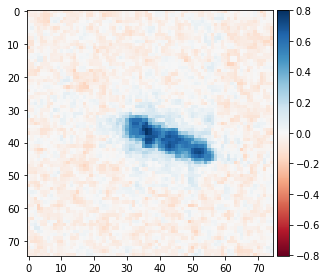

This is: Ship


In [72]:
ix = 100#0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

In [73]:
def imageHistG(image):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    if (image.ndim == 2):
        # Grascale Image
        axis[0].imshow(image, cmap=plt.get_cmap('gray'))
        axis[1].set_title('Histogram')
        axis[0].set_title('Grayscale Image')
        hist = exposure.histogram(image)
        axis[1].plot(hist[0])

In [74]:
def imageHist(image):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    if (image.ndim == 2):
        # Color image
        axis[0].imshow(image, cmap='jet')
        axis[1].set_title('Histogram')
        axis[0].set_title('Colored Image')
        rgbcolors = ['red', 'green', 'blue']
        for i, mycolor in enumerate(rgbcolors):
            axis[1].plot(exposure.histogram(image[...,i])[0], color=mycolor)

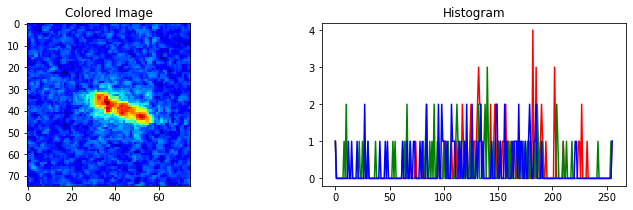

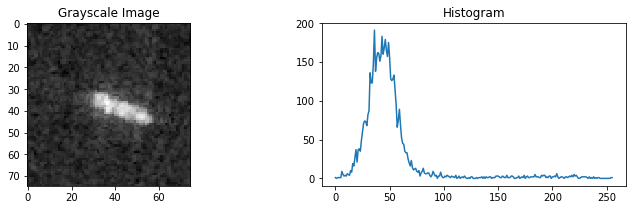

In [75]:
ix = 100
imageHist(X_train[ix,:,:,2])
imageHistG(X_train[ix,:,:,2])

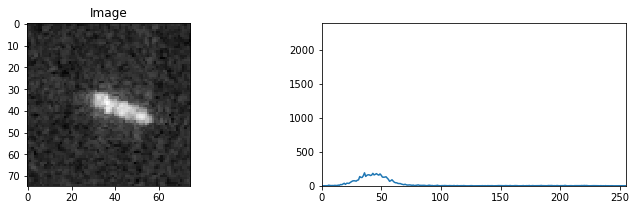

In [76]:
def histGrayScale(img, _xlim=255, _ylim=2400):
    _, axes = plt.subplots(ncols=2, figsize=(12, 3))
    ax = axes.ravel()
    ax[0].imshow(img, cmap=plt.get_cmap('gray'))
    ax[0].set_title('Image')
    hist = exposure.histogram(img)
    ax[1].plot(hist[0])
    # to provide a better display we just change the plot display
    ax[1].set_xlim([0, _xlim])
    ax[1].set_ylim([0, _ylim])
histGrayScale(X_train[ix,:,:,2])

## Iceberg analysis

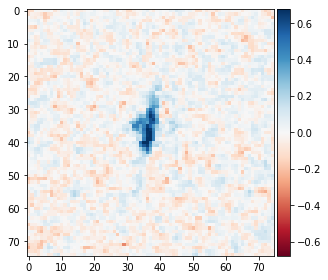

This is: Ship


In [77]:
ix1 = 110 #0-4112
imshow(np.squeeze(X_train[ix1,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

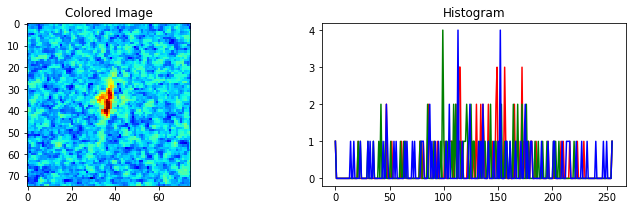

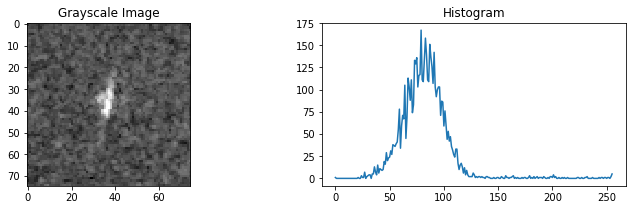

In [78]:
ix = 110
imageHist(X_train[ix,:,:,2])
imageHistG(X_train[ix,:,:,2])

# ANALYSE RGB LAYER

In [79]:
def RGBStats(image): 
    colors = [] 
    for i in range(0, 3): 
        max_color =np.max(image[:,:,i]) 
        min_color =np.min(image[:,:,i]) 
        mean_color = np.mean(image[:,:,i]) 
        median_color = np.median(image[:,:,i]) 
        row = (min_color, max_color, mean_color, median_color)
        colors.append(row)
    return pd.DataFrame(colors,  
                        index = ['Red', ' Green', 'Blue'], 
                        columns = ['Min', 'Max', 'Mean', 'Median'])
 
RGBStats(X_train)

,Min,Max,Mean,Median
Red,-0.613423,0.718828,-0.013360,-0.012173
Green,-0.643982,0.724928,-0.013464,-0.012064
Blue,-0.615498,0.724928,-0.013331,-0.011992


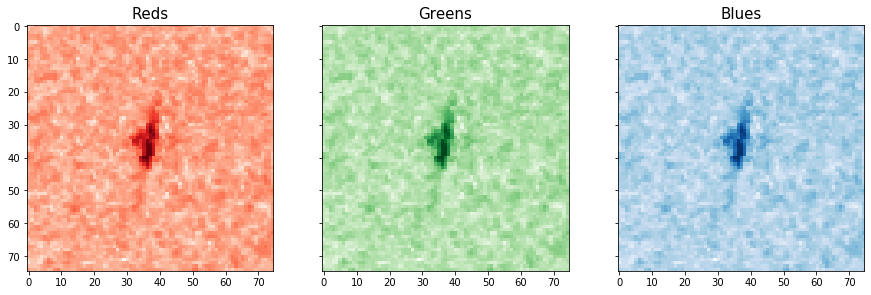

In [80]:
rgb = ['Reds','Greens','Blues'] 
_, axes = plt.subplots(1, 3, figsize=(15,5), sharey = True) 
for i in range(3): 
   axes[i].imshow(X_train[ix,:,:,2], cmap = rgb[i]) 
   axes[i].set_title(rgb[i], fontsize = 15)

# DETECT

On peut ici observer que les icebergs sont en plusieurs parties. Cela peut aider pour la detection. On peut donc lors de la détection poser des limites de périmètres pour aider à réaliser la bonne détection

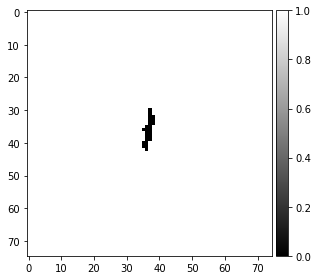

In [81]:
im = np.where(X_train[ix,:,:,2]>128/256, 0, 1)
imshow(im, cmap=plt.get_cmap('gray'));

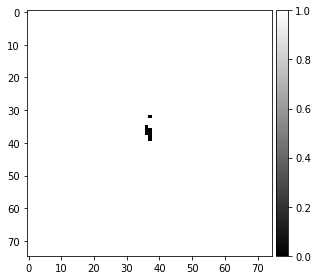

In [82]:
im = np.where(X_train[ix1,:,:,1]>128/256, 0, 1)
imshow(im, cmap=plt.get_cmap('gray'));

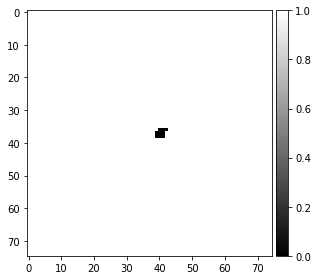

In [83]:
ix = 153 #0-4112data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAT4AAAEYCAYAAADFzZobAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAVp0lEQVR4nO3df4xd513n8fcnTqv+JjYeW6M4g9NdkxKhxkln3VRhIU1ocbKozkqb3aRAvZHRbKQEpRISdXclEOKfIAQqiNBo1IYYUZo1bYpN5G2wBrLdBVpst24ax3Vj3OAMNnYmUMq2guDks3/cM83Nzczce2fO3Otzn89Lurr3Offc5/lOZvzJc37cc2SbiIiSXDLsAiIiBi3BFxHFSfBFRHESfBFRnARfRBQnwRcRxUnwRcRFS9JDks5LemqR9yXptySdlPSkpOt66TfBFxEXs4eB7Uu8fwuwpXpMAR/vpdMVBZ+k7ZJOVGm7eyV9RUR0sv0F4O+XWGUH8Htu+SJwmaTxbv1eutyCJK0BHgDeB8wChyTtt/30Yp9Zv369N2/evNwhI+Ii8+yzzzI3N6f59vbt2z03N9fz548cOXIM+Oe2RdO2p/so4XLgubb2bLXs7FIfWnbwAduAk7ZPAUh6hFb6Lhp8mzdv5vDhwysYMiIuJpOTk69qz83N9fVvXNI/257svubiXSywrOv3cFeyqbtY0r6KpClJhyUdfv7551cwXEQ0ge2eHzWYBa5oa28CznT70EqCr6ektT1te9L25NjY2AqGi4gmGHDw7Qc+VB3dvR74R9tLbubCyjZ1l5W0ETHa6rzik6RPAzcC6yXNAr8EvK4a50HgAHArcBL4LnBXL/2uJPgOAVskXQn8LXAH8MEV9BcRDVfjTG6+vzu7vG/gnn77XXbw2b4g6V7gcWAN8JDtY8vtLyJGQxOu8bmSGR+2D9CaakZEAAUEX0REpwRfRBQnwRcRRbHNyy+/POwyukrwRUStMuOLiOIk+CKiOAm+iChK3Scwr5YEX0TUKsEXEcVJ8EVEcRJ8EVGU7OOLiCIl+CKiOAm+iChOgi8iipPgi4ii5OBGRBQpwRcRxUnwRURxEnwRUZwEX0QUJQc3IqJICb6IKE6CLyKK04Tgu6TbCpIeknRe0lNty9ZJOijpmep57eqWGRFNMb+fr5fHsHQNPuBhYHvHst3AjO0twEzVjojCzd9estfHsHQNPttfAP6+Y/EOYE/1eg9wW811RURDNWHGt9x9fBttnwWwfVbShsVWlDQFTAFMTEwsc7iIaIqR2Me3UranbU/anhwbG1vt4SJiyEZ5xndO0ng12xsHztdZVEQ007ADrVfLnfHtB3ZWr3cC++opJyKabiRmfJI+DdwIrJc0C/wScD+wV9Iu4DRw+2oWGRHN0YQZX9fgs33nIm/dXHMtETECRiL4IiL6keCLiKIMe99drxJ8EVGrBF9EFCfBFxHFaULwrfo3NyKiLHWfxydpu6QTkk5Kes0FUSR9n6Q/lvRVScck3dWtzwRfRNSmn9DrJfgkrQEeAG4BrgbulHR1x2r3AE/bvobWOce/Lun1S/Wb4IuIWtU849sGnLR9yvaLwCO0rg71qiGBt0oS8BZaV5O6sFSn2ccXEbXqcx/fekmH29rTtqfb2pcDz7W1Z4F3d/Tx27S+RnsGeCvwX2wvebG/BF9E1KrP4JuzPbnE+1poiI72TwBHgZuAfwMclPR/bH97sU6zqRsRtap5U3cWuKKtvYnWzK7dXcCjbjkJfBN4x1KdJvgiojZ1H9wADgFbJF1ZHbC4g9ZmbbvTVNcOkLQRuAo4tVSn2dSNiFrVeR6f7QuS7gUeB9YAD9k+Junu6v0HgV8BHpb0NVqbxh+xPbdUvwm+iKhV3Scw2z4AHOhY9mDb6zPA+/vpM8EXEbVqwjc3EnwRURtXt5e82CX4IqJWmfFFRHESfBFRnARfRBQnwRcRRcml5yOiSAm+iChOE4Kv63d1JV0h6c8kHa+ubnpftXydpIOSnqme165+uRFxsav7CsyroZeLFFwAft72DwHXA/dUV0DdDczY3gLMVO2IKNxIBJ/ts7a/XL3+J+A4rYsD7gD2VKvtAW5brSIjohlW4eosq6KvfXySNgPXAl8CNto+C61wlLRhkc9MAVMAExMTK6k1IhpgJPbxzZP0FuCzwIeXurJpJ9vTtidtT46NjS2nxohokJGZ8Ul6Ha3Q+5TtR6vF5ySNV7O9ceD8ahUZEc0xEjO+6s5FnwSO2/6Ntrf2Azur1zuBffWXFxFNMyozvhuAnwG+Julotey/A/cDeyXtonXp59tXp8SIaIphB1qvugaf7f/Lwnc6guo69xER80Yi+CIi+pHgi4jiJPgiojgJvogoysgc3IiI6EeCLyKKk+CLiOIk+CKiKLmvbkQUKTO+iChOgi8iipPgi4jiJPgioig5gTkiipTgi4jiJPgiojgJvogoToIvIoqSgxsRUaQEX0QUJ8EXEcVJ8EVEUZqyj6/rDcUjIvpR9w3FJW2XdELSSUm7F1nnRklHJR2T9L+79ZkZX0TUqs4Zn6Q1wAPA+4BZ4JCk/bafblvnMuB3gO22T0va0K3frjM+SW+Q9FeSvlql6S9Xy9dJOijpmep57XJ/uIgYHTXP+LYBJ22fsv0i8Aiwo2OdDwKP2j5djX++W6e9bOr+C3CT7WuArcB2SdcDu4EZ21uAmaodEYWrOfguB55ra89Wy9r9ILBW0hOSjkj6ULdOu27qulXd/6uar6seppW6N1bL9wBPAB/p1l9EjK5lHNxYL+lwW3va9nRbWwsN09G+FHgXcDPwRuAvJX3R9jcWG7SnfXzVdvYR4N8CD9j+kqSNts8C2D672Ha1pClgCmBiYqKX4SKiwfoMvjnbk0u8Pwtc0dbeBJxZYJ05298BviPpC8A1wKLB19NRXdsv2d5aDbpN0g/38rnqs9O2J21Pjo2N9fqxiGiomjd1DwFbJF0p6fXAHcD+jnX2Af9e0qWS3gS8Gzi+VKd9HdW1/S1JTwDbgXOSxqvZ3jjQdYdiRIy+Oo/q2r4g6V7gcWAN8JDtY5Lurt5/0PZxSZ8HngReBj5h+6ml+u0afJLGgH+tQu+NwI8Dv0ordXcC91fP+5b/40XEKFiN20vaPgAc6Fj2YEf714Bf67XPXmZ848Ceaj/fJcBe249J+ktgr6RdwGng9l4HjYjR1YRvbvRyVPdJ4NoFlr9A6yhKRMT3jETwRUT0I8EXEcVJ8EVEUZpydZYEX0TUKsEXEcVJ8EVEcRJ8EVGcBF9EFCUHNyKiSAm+iChOgi8iipPgi4jiJPgiFiEtdEXx12rCP6J4RQ5uRESREnwRUZwEX0SbbN6WoQm/vwRfRNQqwRcRRcnBjYgoUoIvIoqT4IuI4tR9e8nVkOCLiNpkH19Ehyb8g4iVa8LvOcEXEbVqQvBd0uuKktZI+oqkx6r2OkkHJT1TPa9dvTIjoinmN3d7eQxLz8EH3Accb2vvBmZsbwFmqnZEFG5kgk/SJuA/AJ9oW7wD2FO93gPcVm9pEdE0/YTeRR98wMeAXwDaj1NvtH0WoHresNAHJU1JOizp8PPPP7+iYiPi4jcSwSfpJ4Hzto8sZwDb07YnbU+OjY0tp4uIaJAmBF8vR3VvAD4g6VbgDcDbJP0+cE7SuO2zksaB86tZaEQ0w0gc1bX9UdubbG8G7gD+1PZPA/uBndVqO4F9q1ZlRDTGqMz4FnM/sFfSLuA0cHs9JUVEUw070HrVV/DZfgJ4onr9AnBz/SVFRJONXPBFRHST4IuI4iT4IqI4Cb6IKMpIHtyIiOimCcHXz0UKIiK6qvs8PknbJZ2QdFLSohdDkfTvJL0k6T916zMzvoioVZ0zPklrgAeA9wGzwCFJ+20/vcB6vwo83ku/mfFFRK1qnvFtA07aPmX7ReARWleG6vRzwGfp8auzCb6IqM0qXJbqcuC5tvZstex7JF0O/EfgwV7rzKZuRNSqz03d9ZIOt7WnbU+3tbXQEB3tjwEfsf2StNDqr5Xgi4ha9Xl7yTnbk0u8Pwtc0dbeBJzpWGcSeKQKvfXArZIu2P6jxTpN8EVErWo+neUQsEXSlcDf0rpC1Ac7xrty/rWkh4HHlgo9SPBFRI3qPoHZ9gVJ99I6WrsGeMj2MUl3V+/3vF+vXYIvImpV9wnMtg8ABzqWLRh4tv9rL30m+CKiVk345kaCLyJqleCLiOIk+CKiKLk6S0QUKcEXEcVJ8EVEcRJ8EVGcBF9EFGWkDm5Iehb4J+Al4ILtSUnrgP8JbAaeBf6z7X9YnTIjoimaEHz9XI/vvba3tl1JYTcwY3sLMFO1I6JwdV96fjWs5EKkO4A91es9wG0rLycimm6Ugs/An0g6ImmqWrbR9lmA6nnDahQYEc3ShODr9eDGDbbPSNoAHJT09V4HqIJyCmBiYmIZJUZEUww70HrV04zP9pnq+TzwOVo3ADknaRygel7wJh+2p21P2p4cGxurp+qIuGg1YcbXNfgkvVnSW+dfA+8HngL2Azur1XYC+1aryIhojiYEXy+buhuBz1XXs78U+APbn5d0CNgraRdwGrh99cqMiKZowqZu1+CzfQq4ZoHlLwA3r0ZREdFMw57J9Srf3IiIWiX4IqI4fd5ecigSfBFRq8z4IqIo2ccXEUVK8EVEcRJ8EVGcBF9EFCfBFxFFycGNiChSgi8iipPgi4jiJPgiojgJvogoSg5uRESREnwRUZwEX0QUJ8EXEcVJ8EVEUXJwIyKKlOCLiOIk+CKiOAm+iChOE4LvkmEXEBGjY/7gRq+PXkjaLumEpJOSdi/w/k9JerJ6/IWk19wHvFNPwSfpMkmfkfR1ScclvUfSOkkHJT1TPa/t6aeIiJH28ssv9/zoRtIa4AHgFuBq4E5JV3es9k3gx2y/E/gVYLpbv73O+H4T+LztdwDXAMeB3cCM7S3ATNWOiMLVPOPbBpy0fcr2i8AjwI6O8f7C9j9UzS8Cm7p12jX4JL0N+FHgk9UgL9r+VjX4nmq1PcBtvfwUETHa+gy+9ZIOtz2mOrq7HHiurT1bLVvMLuB/dauxl4MbbweeB3632nY+AtwHbLR9tvpBz0rasNCHqx9kCmBiYqKH4SKiqZZxAvOc7ckl3tdCwyy4ovReWsH3I90G7WVT91LgOuDjtq8FvkMfm7W2p21P2p4cGxvr9WMR0VA1b+rOAle0tTcBZzpXkvRO4BPADtsvdOu0l+CbBWZtf6lqf4ZWEJ6TNF4NOg6c76GviBhxNQffIWCLpCslvR64A9jfvoKkCeBR4Gdsf6OXTrsGn+2/A56TdFW16Gbg6WrwndWyncC+XgaMiNFWZ/DZvgDcCzxO66DqXtvHJN0t6e5qtV8Evh/4HUlHJR3u1m+vJzD/HPCpKnFPAXfRCs29knYBp4Hbe+wrIkZY3Scw2z4AHOhY9mDb658FfrafPnsKPttHgYV2QN7cz2ARMdpydZaIKFKCLyKKk+CLiOIk+CKiOAm+iChKDm5ERJESfBFRnARfRBQnwRcRxUnwRURRcnAjIoqU4IuI4iT4IqI4Cb6IKE6CLyKKYrun20YOW4IvImqVGV9EFCfBFxHFSfBFRFFyAnNEFCnBFxHFSfBFRHESfBFRnARfRBSlKQc3Lum2gqSrJB1te3xb0oclrZN0UNIz1fPaQRQcERe3+fDr5TEsXYPP9gnbW21vBd4FfBf4HLAbmLG9BZip2hFRuJEIvg43A39t+2+AHcCeavke4LY6C4uIZmpC8PW7j+8O4NPV6422zwLYPitpw0IfkDQFTAFMTEwst86IaIiR2Mc3T9LrgQ8Af9jPALanbU/anhwbG+u3vohokH5me02Z8d0CfNn2uap9TtJ4NdsbB87XX15ENM1IzfiAO3llMxdgP7Czer0T2FdXURHRXCMz45P0JuB9wH9rW3w/sFfSLuA0cHv95UVE0zRhxtdT8Nn+LvD9HcteoHWUNyLie0Ym+CIiejHsTdheJfgiolYJvogoToIvIoqT4IuI4iT4IqIoTbmvbr8XKYiIWFLdJzBL2i7phKSTkl5zFSi1/Fb1/pOSruvWZ4IvImpVZ/BJWgM8QOsrs1cDd0q6umO1W4At1WMK+Hi3fhN8EVGrmmd824CTtk/ZfhF4hNYl8drtAH7PLV8ELquuH7Coge7jO3LkyJykvwHWA3ODHLvDsMdPDRfH+Klh5TX8QEf78aqvXr1B0uG29rTt6bb25cBzbe1Z4N0dfSy0zuXA2cUGHWjw2R4DkHTY9uQgx2437PFTw8Uxfmqovwbb2+uop40WGmYZ67xKNnUj4mI2C1zR1t4EnFnGOq+S4IuIi9khYIukK6uLId9B65J47fYDH6qO7l4P/OP81eEXM6zz+Ka7rzLS40NquBjGh9Qw72Ko4TVsX5B0L619h2uAh2wfk3R39f6DwAHgVuAkrZuh3dWtXzXhLOuIiDplUzciipPgi4jiDDT4un31ZJXGfEjSeUlPtS1bJ+mgpGeq57WrOP4Vkv5M0nFJxyTdN4Qa3iDpryR9tarhlwddQ1stayR9RdJjw6hB0rOSvibp6Pz5YwP+XVwm6TOSvl79TbxnwONfVf3s849vS/rwMP4WhmlgwdfjV09Ww8NA57lFu4EZ21uAmaq9Wi4AP2/7h4DrgXuqn3uQNfwLcJPta4CtwPbq6Ncga5h3H3C8rT2MGt5re2vbeWuDrOE3gc/bfgdwDa3/FgMb3/aJ6mffCryL1sGAzw2yhotCv/fBXO4DeA/weFv7o8BHBzT2ZuCptvYJYLx6PQ6cGOB/h320btw0lBqANwFfpnX2+0BroHV+1QxwE/DYMH4XwLPA+o5lA6kBeBvwTaqDioMef4F63g/8+TBrGNZjkJu6i32tZBg2ujrPp3reMIhBJW0GrgW+NOgaqk3Mo7Tuf3zQ9sBrAD4G/ALQft2iQddg4E8kHZE0NeAa3g48D/xutbn/CUlvHuD4ne7glVvGDquGoRhk8PX9tZJRIuktwGeBD9v+9qDHt/2SW5s3m4Btkn54kONL+kngvO0jgxx3ATfYvo7WLpd7JP3oAMe+FLgO+Ljta4HvMKRNyupk4A8AfziM8YdtkMHX99dKVtG5+as3VM/nV3MwSa+jFXqfsv3oMGqYZ/tbwBO09nsOsoYbgA9IepbWFTZukvT7A64B22eq5/O09m1tG2ANs8BsNdsG+AytIBzG38ItwJdtn6vaQ/l7HJZBBl8vXz0ZlP3Azur1Tlr73VaFJAGfBI7b/o0h1TAm6bLq9RuBHwe+PsgabH/U9ibbm2n97v/U9k8PsgZJb5b01vnXtPZxPTWoGmz/HfCcpKuqRTcDTw9q/A538spmLkOqYXgGuUOR1tdKvgH8NfA/BjTmp2ldnuZfaf0fdxetm6PPAM9Uz+tWcfwfobVJ/yRwtHrcOuAa3gl8parhKeAXq+UDq6Gjnht55eDGIP87vB34avU4Nv83OOAatgKHq9/FHwFrB/17oHWA6wXg+9qWDeVvYViPfGUtIoqTb25ERHESfBFRnARfRBQnwRcRxUnwRURxEnwRUZwEX0QU5/8DqXWDRRN0Os4AAAAASUVORK5CYII=
test2 = X_train[ix,:,:,2]
im = np.where(test2>128/256, 0, 1)
imshow(im, cmap=plt.get_cmap('gray'));

# REGARDER PLUS EN DÉTAILS CERTAINES CARACTÉRISTIQUES

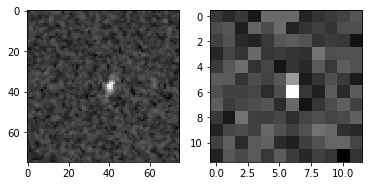

In [84]:
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import exposure, transform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

image_rescaled = transform.rescale(image=test2, scale=1.0 / 6.0, anti_aliasing=False, preserve_range=True)
_, axes = plt.subplots(ncols=2)
axes[0].imshow(test2, cmap=plt.get_cmap('gray'))
axes[1].imshow(image_rescaled, cmap=plt.get_cmap('gray'));

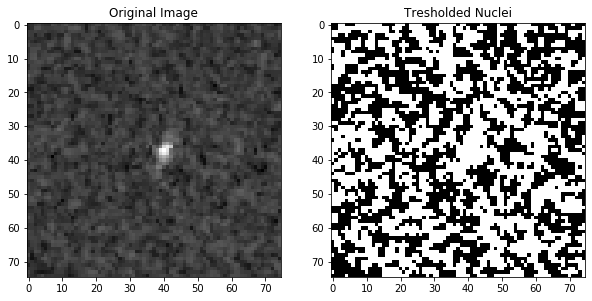

In [85]:
def median_and_otsutresh(img,mediansize = 1,blackbgnd = True):
    # for a function to always work you need to import the libraries used in the function
    from scipy.ndimage import median_filter
    from skimage.filters import threshold_otsu              
    
    medianimg = median_filter(img,mediansize)
    
    tresh = threshold_otsu(medianimg)
    
    # check if the background is black
    if blackbgnd:
        # return thresholded image
        return medianimg > tresh
    
    # background is white
    else:
        # return thresholded image
        return medianimg < tresh

# calling the function
tribolium_binary_function = median_and_otsutresh(test2)    

# plotting------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(10,10))
plt.gray()  

# displaying the two images
ax1.imshow(test2)
ax2.imshow(tribolium_binary_function)

# setting titles
ax1.set_title("Original Image")
ax2.set_title("Tresholded Nuclei")

# showing the plots
plt.show()  

Text(0.5, 1.0, 'Thresholded Image')

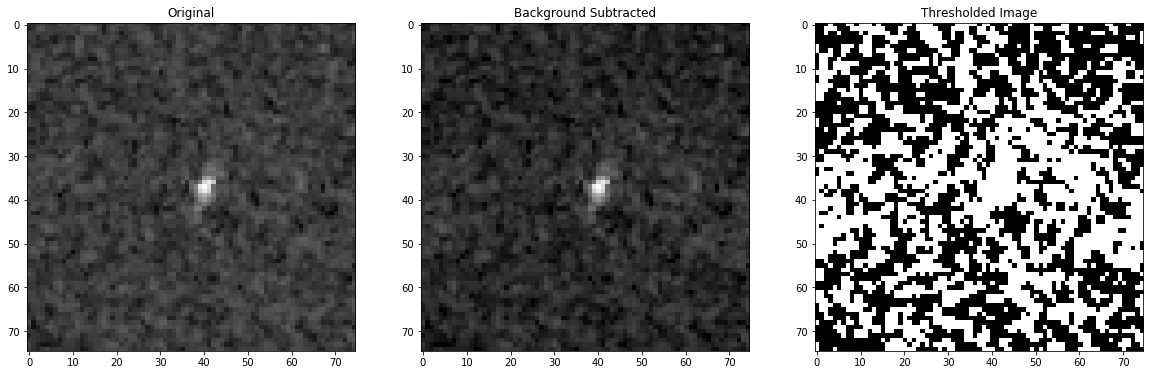

In [86]:
# defining a function for background subtraction
def subtract_background(image, radius=50, light_bg=False):
        #scikit image tophat function and structuring element need to be imported
        from skimage.morphology import white_tophat, black_tophat, disk 
        
        # this structuring element determines the size of background subtraction
        str_el = disk(radius)
        
        if light_bg:
            # the tophat function needs the image as well as the structuring element
            return black_tophat(image, str_el)
        
        else:
            return white_tophat(image, str_el)

# calling the function        
b_sub_triboium = subtract_background(test2,15)        

# thresholding with previous function
thresh_b_sub_trib = median_and_otsutresh(b_sub_triboium)

# plotting-------------------------------------------------------------
# This time we want three plots so we need to change the axes and values accordingly!
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(20,20))

ax1.imshow(test2)
ax1.set_title('Original')

ax2.imshow(b_sub_triboium) 
ax2.set_title('Background Subtracted')

ax3.imshow(thresh_b_sub_trib)
ax3.set_title('Thresholded Image')


# CNN ALGRORITHME

In [87]:
from tensorflow.keras.layers import Input

# We have 2 inputs, 1 for each picture
left_input = Input((75,75,3))
right_input = Input((75,75,3))

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Conv2D, Flatten, Dense

# We will use 2 instances of 1 network for this task
base_network = Sequential([
    Conv2D(5,3, input_shape=(75,75,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])

In [89]:
# Connect both left and right input to the same network
# Remember, they have the same weights
processed_a = base_network(left_input)
processed_b = base_network(right_input)

In [90]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([processed_a, processed_b])

In [91]:
from tensorflow.keras.models import Model

prediction = Dense(1,activation='sigmoid')(processed_a)
siamese_net = Model(inputs=left_input,outputs=prediction)

In [92]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(0.001, decay=2.5e-4)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

In [93]:
siamese_net.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 18)                6912      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 19        
Total params: 6,931
Trainable params: 6,931
Non-trainable params: 0
_________________________________________________________________


In [94]:
import random

# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

In [95]:
cnn=siamese_net.fit(left_input, targets,
          batch_size=16,
          epochs=10,
          verbose=1,
          validation_data=(test_left,test_targets))

Epoch 1/10
313/313 [==============================] - 7s 21ms/step - loss: 0.6950 - accuracy: 0.5124 - val_loss: 0.6961 - val_accuracy: 0.5095
Epoch 2/10
313/313 [==============================] - 6s 20ms/step - loss: 0.6942 - accuracy: 0.5104 - val_loss: 0.6933 - val_accuracy: 0.4905
Epoch 3/10
313/313 [==============================] - 6s 20ms/step - loss: 0.6924 - accuracy: 0.5214 - val_loss: 0.6933 - val_accuracy: 0.5095
Epoch 4/10
313/313 [==============================] - 6s 20ms/step - loss: 0.6918 - accuracy: 0.5286 - val_loss: 0.6958 - val_accuracy: 0.5095
Epoch 5/10
313/313 [==============================] - 6s 20ms/step - loss: 0.6913 - accuracy: 0.5244 - val_loss: 0.6931 - val_accuracy: 0.5095
Epoch 6/10
313/313 [==============================] - 6s 20ms/step - loss: 0.6899 - accuracy: 0.5292 - val_loss: 0.6969 - val_accuracy: 0.4905
Epoch 7/10
313/313 [==============================] - 6s 20ms/step - loss: 0.6880 - accuracy: 0.5458 - val_loss: 0.6973 - val_accuracy: 0.4905

# ÉVALUATION

In [96]:


#create a dataframe of the model training history
results = pd.DataFrame(cnn.history)
results.head()



,loss,accuracy,val_loss,val_accuracy
0,0.694988,0.5124,0.696093,0.509476
1,0.694238,0.5104,0.693273,0.490524
2,0.692410,0.5214,0.693321,0.509476
3,0.691807,0.5286,0.695773,0.509476
4,0.691335,0.5244,0.693083,0.509476


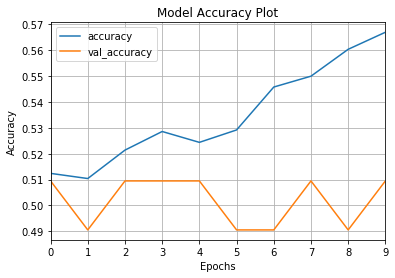

In [97]:
#plot the accuracy over the training and test set
results[['accuracy','val_accuracy']].plot()
plt.title('Model Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

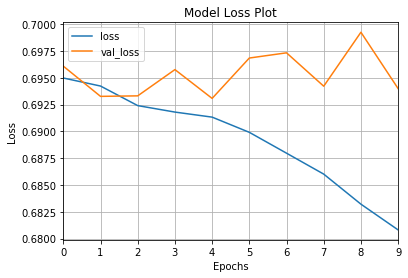

In [98]:
#plot the loss over the training and test set
results[['loss','val_loss']].plot()
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

https://biapol.github.io/blog/ryan_savill/02_intro_to_skimage/

https://www.kaggle.com/saurabhbagchi/ship-and-iceberg-dataset-for-starters

In [99]:
import pickle
import tempfile
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.layers import Dense

# Hotfix function
def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

# Run the function
make_keras_picklable()


In [100]:
model = siamese_net

In [101]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("/home/apprenant/PycharmProjects/ClimateProject---E3/model/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/home/apprenant/PycharmProjects/ClimateProject---E3/model/model.h5")